In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 필요한 패키지와 라이브러리 가져온다.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 폰트 지정하기
plt.rcParams['font.family'] = 'gulim'

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_28264\3242504639.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [14]:
weather = pd.read_csv('../data/기상대기정보.csv', encoding='UTF-8')
weather.head(2)

,지점명,일시,지점,기온(°C),강수여부,풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),...,Ozon,NO2,CO,SO2,증기압(hPa),이슬점온도(°C),시정(10m),지면온도(°C),월,전날기온
0,철원,2018-08-02 01:00:00,95,28.2,0,1.0,50.0,79.0,987.3,1004.6,...,0.023,0.003,0.3,0.001,30.2,24.2,1522.0,27.7,8,25.0
1,철원,2018-08-02 02:00:00,95,27.3,0,0.7,90.0,85.0,987.5,1004.9,...,0.024,0.003,0.3,0.001,30.7,24.5,1346.0,26.8,8,24.2


In [15]:
weather['지점명'].unique()

array(['철원', '동두천', '파주', '백령도', '동해', '서울', '인천', '원주', '울릉도', '수원',
       '충주', '서산', '대전', '상주', '포항', '대구', '울산', '창원', '광주', '부산', '목포',
       '여수', '순천', '홍성', '제주', '서귀포', '진주', '강화', '양평', '정선군', '제천', '천안',
       '임실', '고창군', '영광군', '김해시', '순창군', '해남', '광양시', '영주', '거창', '밀양',
       '거제', '속초', '영월', '울진', '완도', '인제', '홍천', '태백', '보성군', '장흥', '함양군',
       '합천', '이천', '봉화'], dtype=object)

# 서울 관측소 기온 시계열 분석

In [16]:
w_seoul = weather[weather['지점명']=='서울'][['일시','기온(°C)']]
w_seoul.head(2)

,일시,기온(°C)
20325,2018-01-01 00:00:00,-3.2
20326,2018-01-01 03:00:00,-4.0


In [17]:
w_seoul['일시'] = pd.to_datetime(w_seoul['일시'])

In [18]:
w_seoul['일시'] = w_seoul['일시'].dt.date

In [19]:
w_seoul = w_seoul.groupby('일시').mean()

In [20]:
w_seoul.index = pd.to_datetime(w_seoul.index)

In [21]:
# 학습용, 검증용 데이터 분리
w_tr = w_seoul[w_seoul.index<'2022-07-01']
w_te = w_seoul[w_seoul.index>='2022-07-01']

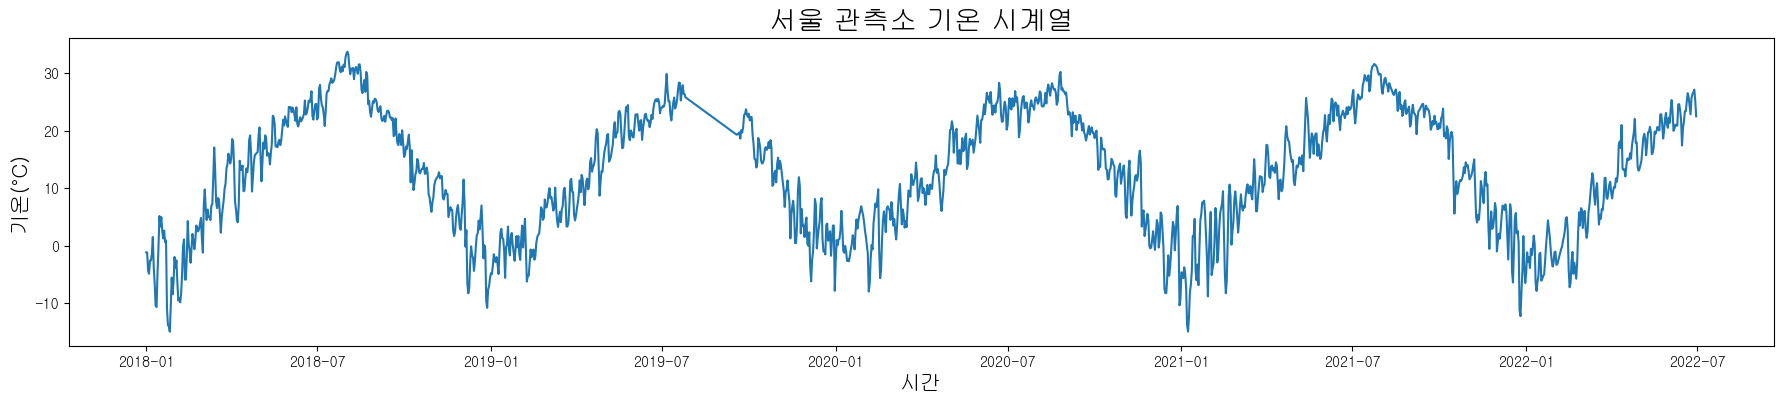

In [22]:
# 시계열 그래프
plt.figure(figsize=(22,4))
plt.plot(w_tr.index, w_tr['기온(°C)'].values)
plt.title('서울 관측소 기온 시계열', fontsize=20)
plt.xlabel('시간(일)', fontsize=15)
plt.ylabel('기온(°C)', fontsize=15)
plt.show()

In [146]:
w_seoul.index[(w_seoul.index > '2019-07-26') & (w_seoul.index < '2019-9-30')]

DatetimeIndex(['2019-09-18', '2019-09-19', '2019-09-20', '2019-09-21',
               '2019-09-22', '2019-09-23', '2019-09-24', '2019-09-25',
               '2019-09-26', '2019-09-27', '2019-09-28', '2019-09-29'],
              dtype='datetime64[ns]', name='일시', freq=None)

### 시계열 그래프 해석
- 우리가 평소 아는 것과 같이 일년을 주기로 계절성을 보임

## 시계열 분해

<Figure size 640x480 with 0 Axes>

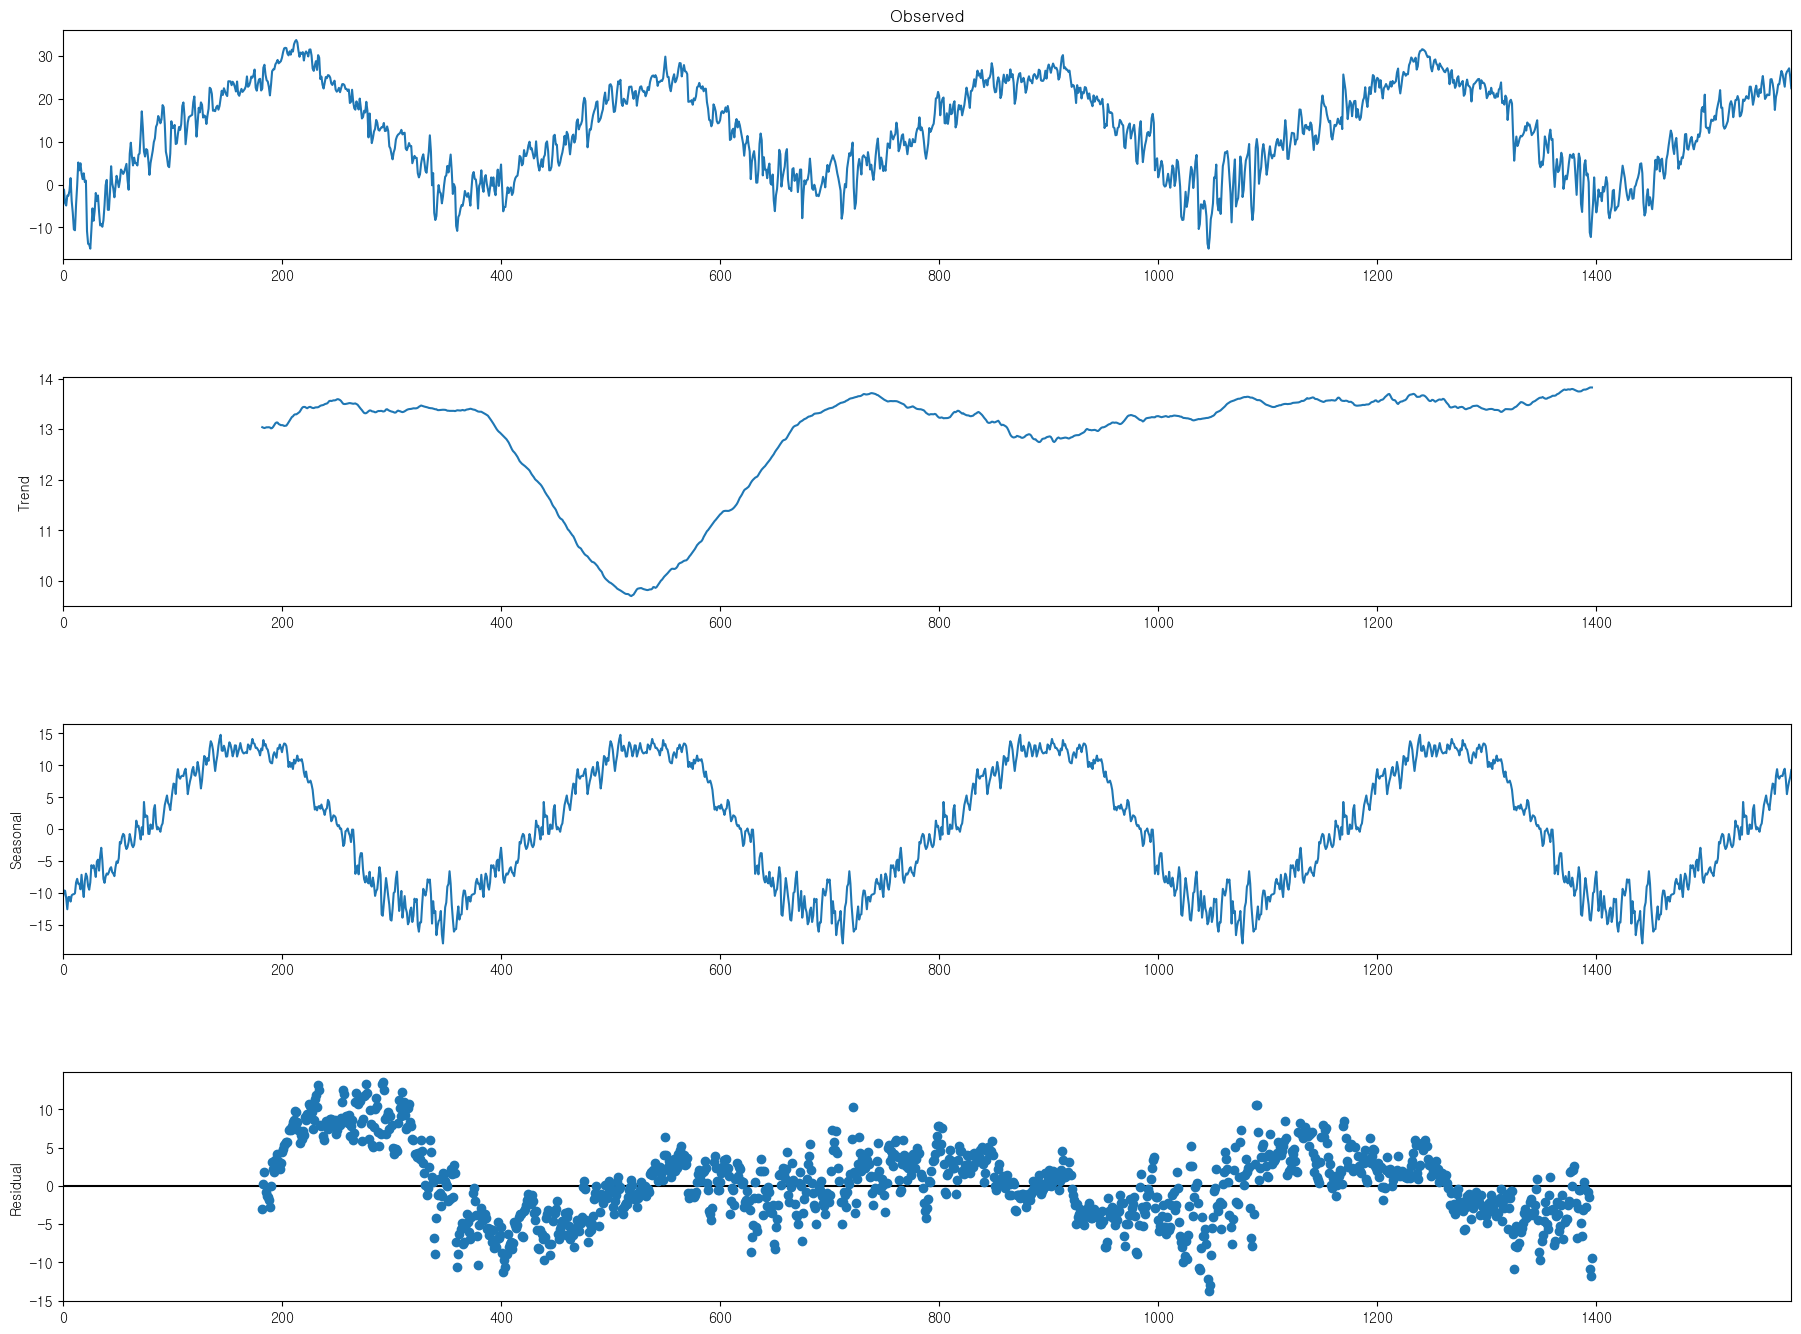

In [24]:
result = seasonal_decompose(w_tr['기온(°C)'].values, model='additive', period=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

## 시계열 분해 그래프 해석
- 계절성에서 패턴이 보이고, 불규칙 요소에서도 패턴이 보임
- 정상성을 만족하지 못 할 것을 예상할 수 있음

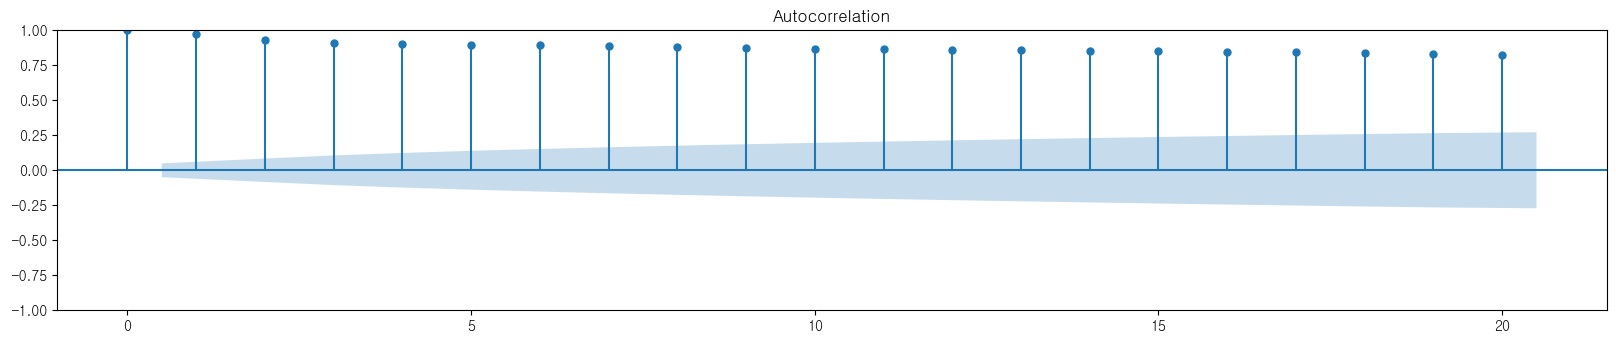

In [25]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(w_tr['기온(°C)'].values, lags=20, ax=ax1)

In [26]:
adfuller(w_tr['기온(°C)'].values) # p-value: 0.279

(-2.017210602346955,
 0.27907820537711725,
 19,
 1559,
 {'1%': -3.4345514752023365,
  '5%': -2.863395697445539,
  '10%': -2.567757942139848},
 6983.313498828342)

### ACF 값 그래프 해석
- ACF 값이 아주 천천히 감소: 정상성 만족 못할 것을 예상
- ADF 검정 결과: H0 기각 못함 = 정상성 만족 못함

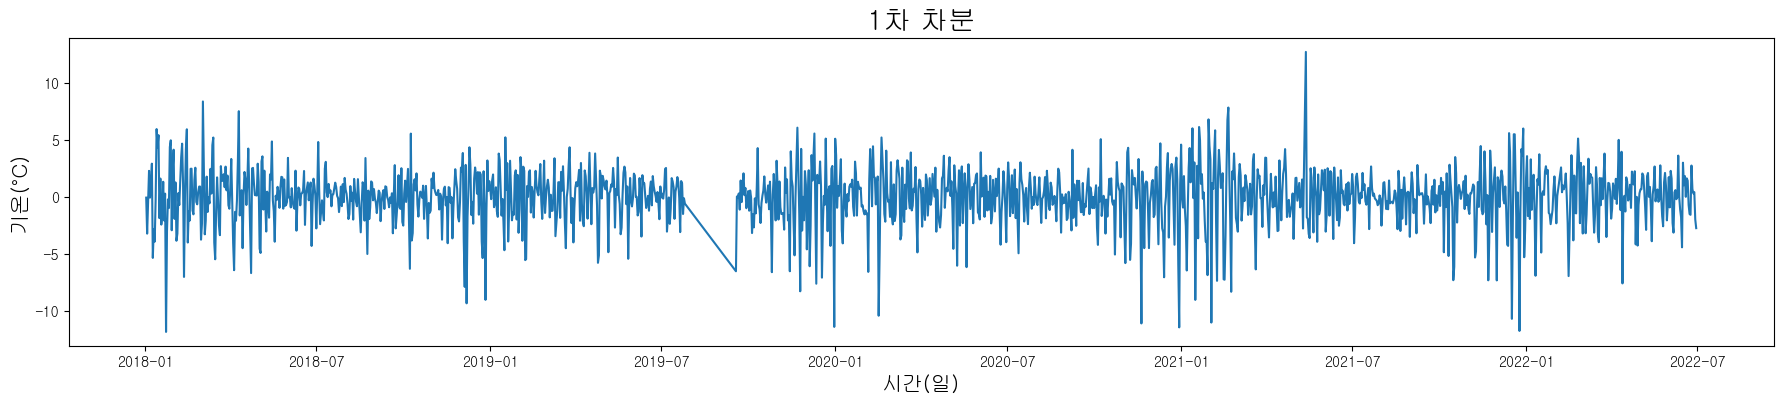

In [135]:
# 1차 차분
w_tr_diff = w_tr['기온(°C)'] - w_tr['기온(°C)'].shift()
plt.figure(figsize=(22,4))
plt.plot(w_tr_diff)
plt.title('1차 차분', fontsize=20)
plt.xlabel('시간(일)', fontsize=15)
plt.ylabel('기온(°C)', fontsize=15)
plt.show()

In [28]:
adfuller(w_tr_diff.values[1:]) # p-value: 3.669e-11

(-7.526660499911265,
 3.66949882295327e-11,
 24,
 1553,
 {'1%': -3.4345677345088688,
  '5%': -2.8634028737525887,
  '10%': -2.5677617635268795},
 6975.908916236074)

### 1차 차분 그래프 해석
- 일정한 패턴이 사라짐
- 정상성 만족할 것을 예상
- ADF 검정 결과: H0 기각 = 정상성 만족
- d = 1

c:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


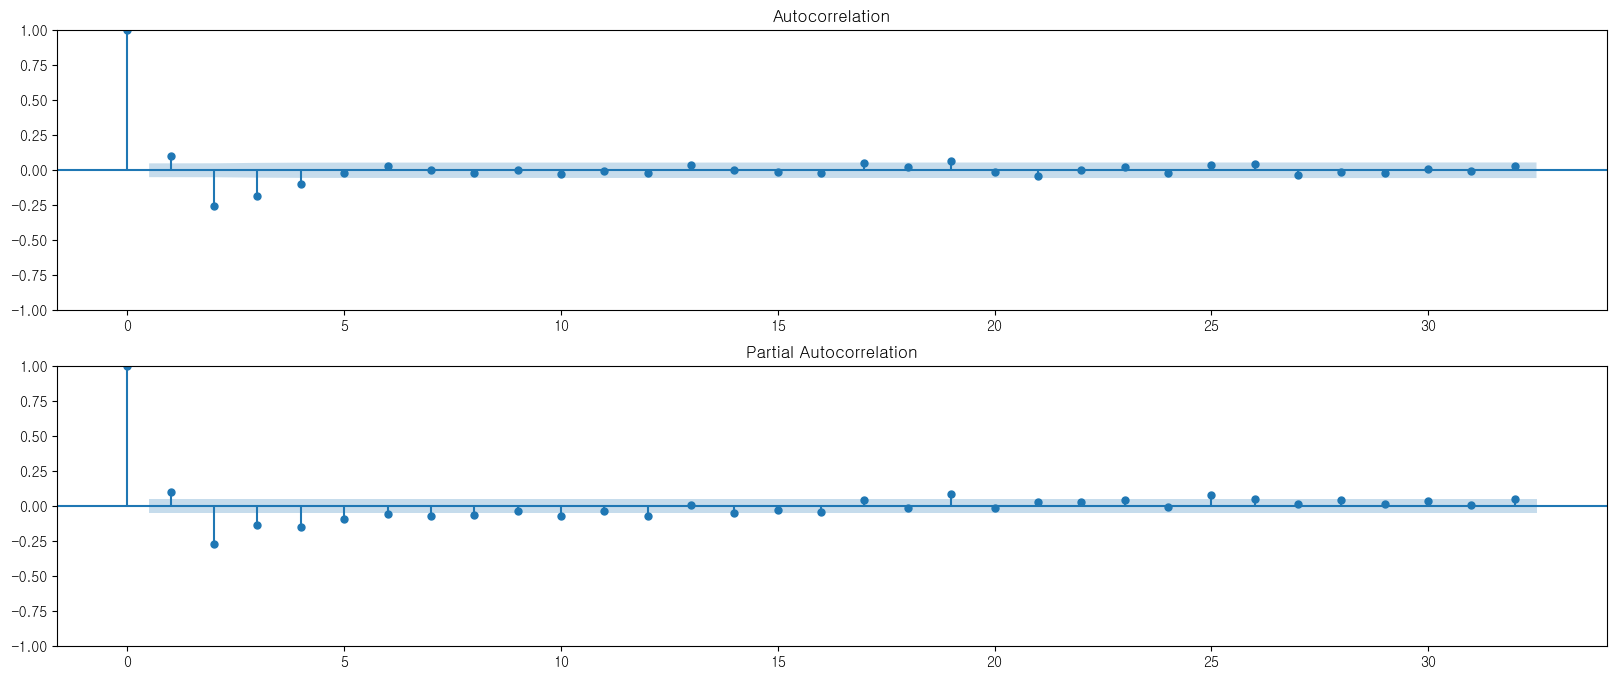

In [29]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(w_tr_diff.values[1:], ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(w_tr_diff.values[1:], ax=ax2)

### 차분 데이터로 그린 ACF와 PACF 그래프 해석
- ACF 그래프는 4번째 lag 이후에 0에 수렴
- PACF 그래프는 5번째 lag 이후에 0에 수렴
- p = 5, q = 4

In [127]:
# ARIMA(5,1,4) 모형
model = ARIMA(w_tr['기온(°C)'], order = (2,1,3)).fit()
predictions = model.predict(start=365-len(w_te)+1, end=365,dynamic=False)
predictions.index = pd.date_range(start='2022-07-01', end='2022-12-31')
predictions

c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2022-07-01    22.048492
2022-07-02    23.530242
2022-07-03    27.824311
2022-07-04    26.949493
2022-07-05    25.013488
                ...    
2022-12-27    -7.963677
2022-12-28    -5.675946
2022-12-29    -6.209910
2022-12-30    -4.758852
2022-12-31    -4.612086
Freq: D, Name: predicted_mean, Length: 184, dtype: float64

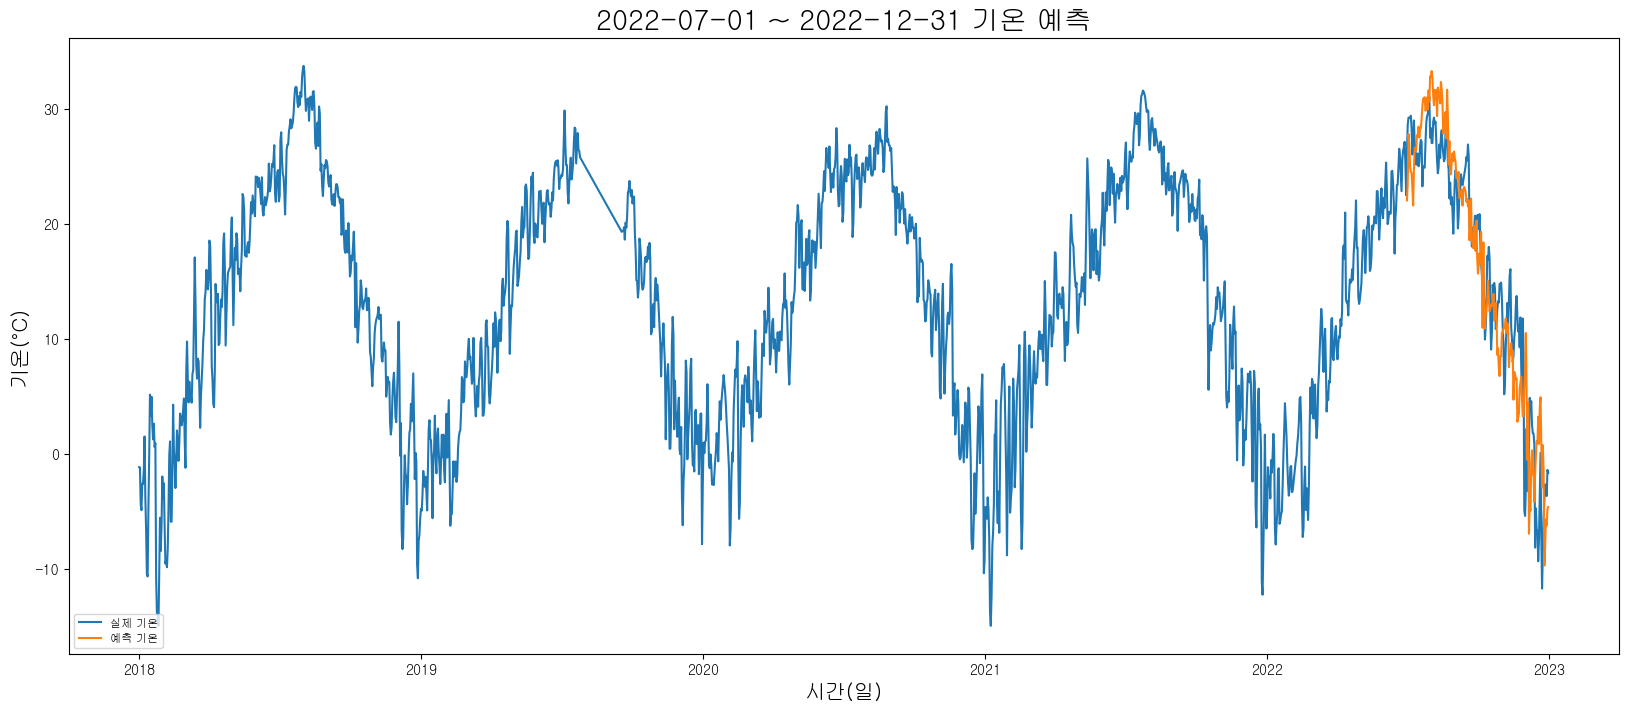

In [134]:
plt.figure(figsize=(20,8))
plt.plot(w_seoul['기온(°C)'],label='실제 기온')
plt.plot(predictions,label='예측 기온')
plt.legend(loc='lower left',fontsize=8)
plt.title('2022-07-01 ~ 2022-12-31 기온 예측', fontsize=20)
plt.xlabel('시간(일)', fontsize=15)
plt.ylabel('기온(°C)', fontsize=15)
plt.show()